# Learning a Repertoire of Robot Arm Configurations

In robotic manipulation, [inverse kinematics](https://en.wikipedia.org/wiki/Inverse_kinematics) involves figuring out how to configure the joints of an arm such that the end effector is at a certain position. For instance, in order to pick up a cup, a robot must move its gripper to the cup's position, and in order to catch a ball, a robot must move its hand to where it predicts the ball will be.

In this tutorial, we will show how to use CMA-ME to find a repertoire of joint angles that move a robotic arm to a wide variety of positions. For simplicity, we will use a planar 12-DoF arm, i.e. an arm with 12 joints that only moves in 2D space.

This tutorial is based on the benchmark introduced in [Vassiliades 2018](https://arxiv.org/abs/1804.03906).

## Setup

First, we install pyribs.

In [ ]:
%pip install ribs[visualize]

And here we import some utilities.

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np

## Problem Description

Our arm consists of 12 joints and links of length 1. It looks something like the following, where the red dot is the base of the arm, the green dot is the position of the end effector, and each black dot is an intermediate joint (note that the base also counts as a joint). Since the total length of the arm is 12 units, the arm can only move to positions in a circle of radius 12 around its base.

![Arm repertoire example](_static/arm_repertoire_example.png)

Each solution $\theta$ consists of 12 joint angles for the arm, and each angle $\theta_i$ is bounded by $[-\pi, \pi]$ (i.e. each joint has a full range of motion).

Since we want to move the arm to a wide variety of positions, our measures are the final $(x,y)$ coordinates of the arm. To calculate these coordinates, we use these [forward kinematics](https://en.wikipedia.org/wiki/Forward_kinematics) equations:

$$x = l_1 \cos(\theta_1) + l_2 \cos(\theta_1 + \theta_2) + ... + l_{12} \cos(\theta_1 + \theta_2 + ... \theta_{12})$$

$$y = l_1 \sin(\theta_1) + l_2 \sin(\theta_1 + \theta_2) + ... + l_{12} \sin(\theta_1 + \theta_2 + ... \theta_{12})$$


Where $l_i$ is the length of the $i$-th link (in our case, $l_i$ is always 1).

There are many possible objectives to use. For instance, in a real-world setting, we may choose to minimize the movement of certain joints, as they may be weaker or more prone to wear-and-tear. Here, we choose to maximize the negative standard deviation of the joint angles (i.e. minimize the standard deviation), such that the joint angles are as close to each other as possible. This will make the arm look like a smooth curve in its final position.

The following `simulate` function calculates the objectives and measures for a batch of solutions.

In [3]:
def simulate(solutions, link_lengths):
    """Returns the objective values and measures for a batch of solutions.
    
    Args:
        solutions (np.ndarray): A (batch_size, dim) array where each row
            contains the joint angles for the arm. `dim` will always be 12
            in this tutorial.
        link_lengths (np.ndarray): A (dim,) array with the lengths of each
            arm link (this will always be an array of ones in the tutorial).
    Returns:
        objs (np.ndarray): (batch_size,) array of objectives.
        meas (np.ndarray): (batch_size, 2) array of measures.
    """
    n_dim = link_lengths.shape[0]
    objs = -np.std(solutions, axis=1)

    # theta_1, theta_1 + theta_2, ...
    cum_theta = np.cumsum(solutions, axis=1)
    # l_1 * cos(theta_1), l_2 * cos(theta_1 + theta_2), ...
    x_pos = link_lengths[None] * np.cos(cum_theta)
    # l_1 * sin(theta_1), l_2 * sin(theta_1 + theta_2), ...
    y_pos = link_lengths[None] * np.sin(cum_theta)

    meas = np.concatenate(
        (
            np.sum(x_pos, axis=1, keepdims=True),
            np.sum(y_pos, axis=1, keepdims=True),
        ),
        axis=1,
    )

    return objs, meas

## Quality Diversity Algorithm Setup

We will use CMA-ME, with the following pyribs components, to search for arm configurations:

- `CVTArchive`: This archive uses a [Centroidal Voronoi Tesselation (CVT)](https://en.wikipedia.org/wiki/Centroidal_Voronoi_tessellation) to divide the measure space into evenly sized cells. It is typically used for high-dimensional measure spaces where the curse of dimensionality prevents one from using `GridArchive`, but it works perfectly fine for lower dimensions too.
- `EvolutionStartegyEmitter`: This emitter is used to create the improvement emitter which originated in [Fontaine 2020](https://arxiv.org/abs/1912.02400). It uses CMA-ES to search for solutions that improve the archive.
- `Scheduler`: Binds all the components together.

First, let's create the archive. This line may take a minute or two to run because it initializes the archive, and initializing `CVTArchive` involves using [k-means clustering (Lloyd's algorithm)](https://scikit-learn.org/stable/modules/clustering.html#k-means) to generate the CVT.

In [4]:
from ribs.archives import CVTArchive

dof = 12  # Degrees of freedom for the arm.
link_lengths = np.ones(dof)  # 12 links, each with length 1.
max_pos = np.sum(link_lengths)
archive = CVTArchive(
    solution_dim=dof,
    cells=10000,
    # The x and y coordinates are bound by the maximum arm position.
    ranges=[(-max_pos, max_pos), (-max_pos, max_pos)],
    # The archive will use a k-D tree to search for the cell a solution
    # belongs to.
    use_kd_tree=True,
)

Now, the emitters. We will we use 5 instances of `EvolutionStrategyEmitter` with two-stage improvement ranking ("2imp"), each with a batch size of 30. This means we will evaluate 150 solutions (5 x 30) on each iteration of the algorithm. As described earlier, we also bound each angle to be between $-\pi$ and $\pi$.

In [5]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive=archive,
        x0=np.zeros(dof),
        # Initial step size of 0.1 seems reasonable based on the bounds.
        sigma0=0.1,
        ranker="2imp",
        bounds=[(-np.pi, np.pi)] * dof,
        batch_size=30,
    ) for _ in range(5)  # Create 5 separate emitters.
]

Finally, the scheduler combines everything together.

In [6]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

## Training

With our algorithm set up, we can now search for arm configurations. We also extract metrics throughout our training loop.

In [7]:
metrics = {
    "Archive Size": {
        "itrs": [0],
        "vals": [0],  # Starts at 0.
    },
    "Max Objective": {
        "itrs": [],
        "vals": [],  # Does not start at 0.
    },
}

start_time = time.time()
total_itrs = 700
for itr in range(1, total_itrs + 1):
    sols = scheduler.ask()
    objs, meas = simulate(sols, link_lengths)
    scheduler.tell(objs, meas)

    # Logging.
    if itr % 50 == 0:
        metrics["Archive Size"]["itrs"].append(itr)
        metrics["Archive Size"]["vals"].append(len(archive))
        metrics["Max Objective"]["itrs"].append(itr)
        metrics["Max Objective"]["vals"].append(archive.stats.obj_max)
        print(f"Finished {itr} itrs after {time.time() - start_time:.2f} s")

Finished 50 itrs after 5.52 s
Finished 100 itrs after 5.80 s
Finished 150 itrs after 6.10 s
Finished 200 itrs after 6.49 s
Finished 250 itrs after 6.76 s
Finished 300 itrs after 7.02 s
Finished 350 itrs after 7.29 s
Finished 400 itrs after 7.56 s
Finished 450 itrs after 7.83 s
Finished 500 itrs after 8.09 s
Finished 550 itrs after 8.36 s
Finished 600 itrs after 8.63 s
Finished 650 itrs after 8.91 s
Finished 700 itrs after 9.17 s


We can now plot the metrics.

Final Archive Size: 7856
Final Max Objective: -0.012407225060006162


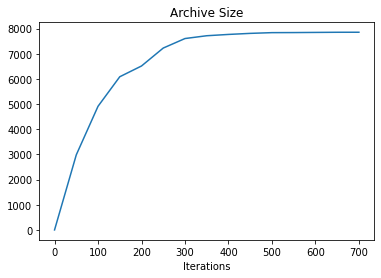

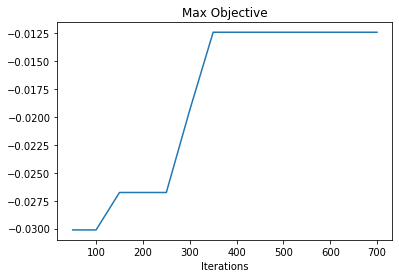

In [8]:
for metric in metrics:
    plt.figure()
    plt.plot(metrics[metric]["itrs"], metrics[metric]["vals"])
    plt.title(metric)
    plt.xlabel("Iterations")
    print(f"Final {metric}: {metrics[metric]['vals'][-1]}")

Using the `cvt_archive_heatmap` from `ribs.visualize`, we can also plot a heatmap showing all the positions for which we found an arm configuration, as well as the objective value of each configuration (higher is better). As we can see, CMA-ME found a solution for most of the possible positions (the arm can reach anywhere within a circle of radius 12 around its base), but there are still a few gaps.

Text(0.5, 1.0, 'Final Positions of a 12-DoF Arm')

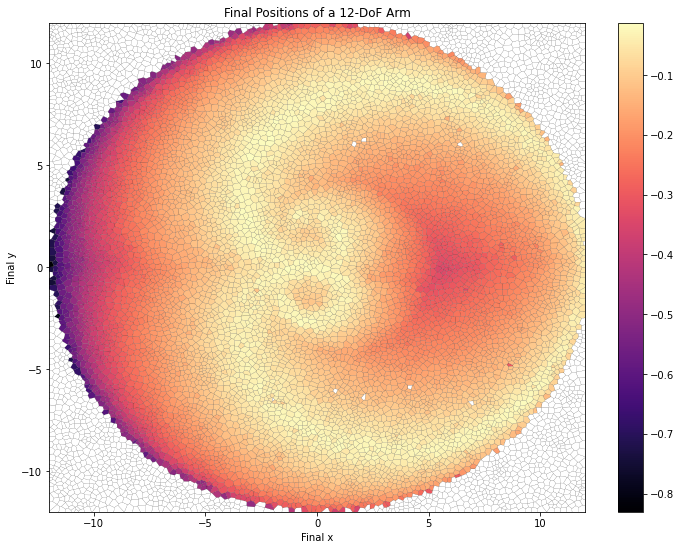

In [9]:
from ribs.visualize import cvt_archive_heatmap

plt.figure(figsize=(12, 9))
cvt_archive_heatmap(archive, plot_centroids=False, lw=0.1)
plt.xlabel("Final x")
plt.ylabel("Final y")
plt.title("Final Positions of a 12-DoF Arm")

## Visualization

Finally, we can visualize some of the arm configurations that we found. The following function displays a plot of the arm like the one shown at the beginning of this tutorial.

In [10]:
def visualize(solution, link_lengths, objective, ax):
    """Plots an arm with the given angles and link lengths on ax.
    
    Args:
        solution (np.ndarray): A (dim,) array with the joint angles of the arm.
        link_lengths (np.ndarray): The length of each link the arm.
        objective (float): The objective of this solution.
        ax (plt.Axes): A matplotlib axis on which to display the arm.
    """
    lim = 1.05 * np.sum(link_lengths)  # Add a bit of a border.
    ax.set_aspect("equal")
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    ax.set_title(f"Objective: {objective}")

    # Plot each link / joint.
    pos = np.array([0, 0])  # Starting position of the next joint.
    cum_thetas = np.cumsum(solution)
    for link_length, cum_theta in zip(link_lengths, cum_thetas):
        # Calculate the end of this link.
        next_pos = pos + link_length * np.array(
            [np.cos(cum_theta), np.sin(cum_theta)])
        ax.plot([pos[0], next_pos[0]], [pos[1], next_pos[1]], "-ko", ms=3)
        pos = next_pos

    # Add points for the start and end positions.
    ax.plot(0, 0, "ro", ms=6)
    final_label = f"Final: ({pos[0]:.2f}, {pos[1]:.2f})"
    ax.plot(pos[0], pos[1], "go", ms=6, label=final_label)
    ax.legend()

We can retrieve `n` random solutions from the archive with `sample_elites(n)`. As our objective was to find configurations where the joint angles had small standard deviation from each other, it makes sense that all of our arms look "smooth" when visualized, as the joint angles are close to each other.

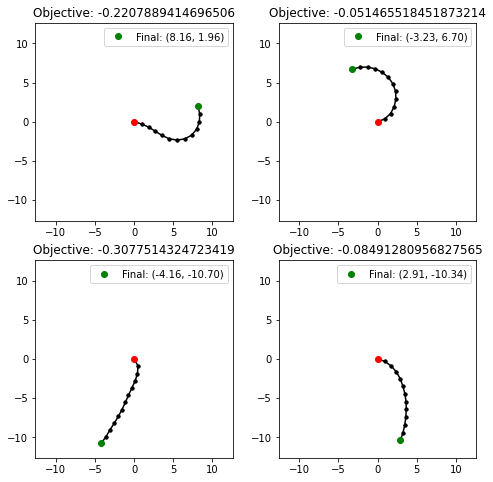

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.ravel()
elite_batch = archive.sample_elites(len(ax))
for i in range(len(ax)):
    visualize(elite_batch.solution_batch[i], link_lengths,
              elite_batch.objective_batch[i], ax[i])

We can also retrieve solutions that reached specific positions with `elites_with_measures_single`. This method will check whether the archive cell with the specified measures contains a solution, and if so, it will return that solution. It looks like there is an arm configuration that can reach position (0,0), so let's see what that looks like.

If you want to query a batch of solutions, you can similarly use `elites_with_measures`.

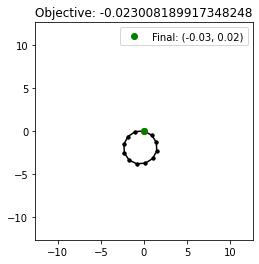

In [12]:
elite = archive.elites_with_measures_single([0, 0])
_, ax = plt.subplots()
if elite.solution is not None:  # This is None if there is no solution for [0,0].
    visualize(elite.solution, link_lengths, elite.objective, ax)

As one might expect, the arm looks like a circle, as the joint angles in a circle are all equal. Since `elites_with_measures_single` retrieves a solution in the same _cell_ as the measures specified, the actual measures of the solution may not exactly match (0,0).

## Conclusion

We discussed inverse kinematics, the problem of finding joint configurations that place an arm's end effector at a specified position. Using CMA-ME with a CVT archive and five improvement emitters, we then created a repertoire of joint configurations that move a 12-DoF planar arm to a wide variety of positions. Finally, we visualized some of the solutions we retrieved. Some ideas for future experiments include:

- Increasing the number of joints (increase `dof` under the Quality Diversity Algorithm Setup section)
- Using different link lengths (set `link_lengths` in the same section as `dof`)
- Using different types of emitters, like the `EvolutionStrategyEmitter` with random direction ranking or the `IsoLineEmitter`

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_arm_repertoire,
  title   = {Learning a Repertoire of Robot Arm Configurations},
  author  = {Bryon Tjanaka and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2021},
  url     = {https://docs.pyribs.org/en/stable/tutorials/arm_repertoire.html}
}
```